# Lightweight face mask removal

In [1]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from keras.utils import plot_model

2023-02-17 18:59:49.192193: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


## 1) Preconditions
First we need a dataset of human faces.

In [3]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

In [4]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print('Testing and training data already generated')
else:
    dg.generate_images()

2023-02-17 18:59:54.977514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 18:59:55.763321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14056 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6


Testing and training data already generated


## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [5]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESIDUAL_ATTENTION_UNET_SEPARABLE_CONV
training_epochs = 40
batch_size = 20

In [6]:
from utils.model import Mask2FaceModel
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
# model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ms_ssim_perceptual_loss')

# If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('path_to_your_trained_model.h5')

Using UNet Resnet model with attention mechanism and separable convolutions


In [7]:
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ms_ssim_l1_perceptual_loss')

Loading training data from data/train with limit of 24000 images
Loading testing data from data/test with limit of 1000 images


2023-02-17 19:00:13.191097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


5/5 [==============================] - 12s 444ms/step - loss: 0.8864 - acc: 0.1803 - recall: 0.9158 - precision: 0.9938
- TEST -> LOSS:     0.8864, ACC:     0.1803, RECALL:     0.9158, PRECISION:     0.9938
Epoch 1/40


2023-02-17 19:00:39.494268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 5000
2023-02-17 19:00:49.508890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 907 of 5000
2023-02-17 19:00:59.495442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1361 of 5000
2023-02-17 19:01:09.496042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1955 of 5000
2023-02-17 19:01:19.497190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2412 of 5000
2023-02-17 19:01:29.508761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2862 of 5000
2023-02-17 19:01:39.502986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuff

176/960 [====>.........................] - ETA: 22:04 - loss: 0.7343 - acc: 0.4874 - recall: 0.7677 - precision: 1.0000

InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19215/1269338.py", line 1, in <module>
      model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ms_ssim_l1_perceptual_loss')
    File "/home/suresh/Project_unmask/Archives/mask2face/utils/model.py", line 230, in train
      history = self.model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=callbacks)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/metrics/metrics.py", line 960, in update_state
      sample_weight=sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 605, in update_confusion_matrix_variables
      message='predictions must be >= 0'),
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19215/1269338.py", line 1, in <module>
      model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ms_ssim_l1_perceptual_loss')
    File "/home/suresh/Project_unmask/Archives/mask2face/utils/model.py", line 230, in train
      history = self.model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=callbacks)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/metrics/metrics.py", line 960, in update_state
      sample_weight=sample_weight)
    File "/home/suresh/miniconda3/envs/unmask/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 605, in update_confusion_matrix_variables
      message='predictions must be >= 0'),
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_3/separable_conv2d_40/Sigmoid:0) = ] [[[[nan nan nan]]]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[Adam/gradients/PartitionedCall/gradients/MS-SSIM/Prod_grad/Shape/_202]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_3/separable_conv2d_40/Sigmoid:0) = ] [[[[nan nan nan]]]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_28923]

In [16]:
model.compile(
            loss=Mask2FaceModel.ssim_l1_loss,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
        )

In [17]:
model.build(input_shape=(None, 256, 256, 3))

In [18]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 256, 256, 64  9472        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_64 (Conv2D)             (None, 128, 128, 64  200768      ['conv2d_63[0][0]']              
                                )                                                           

Using UNet Resnet model


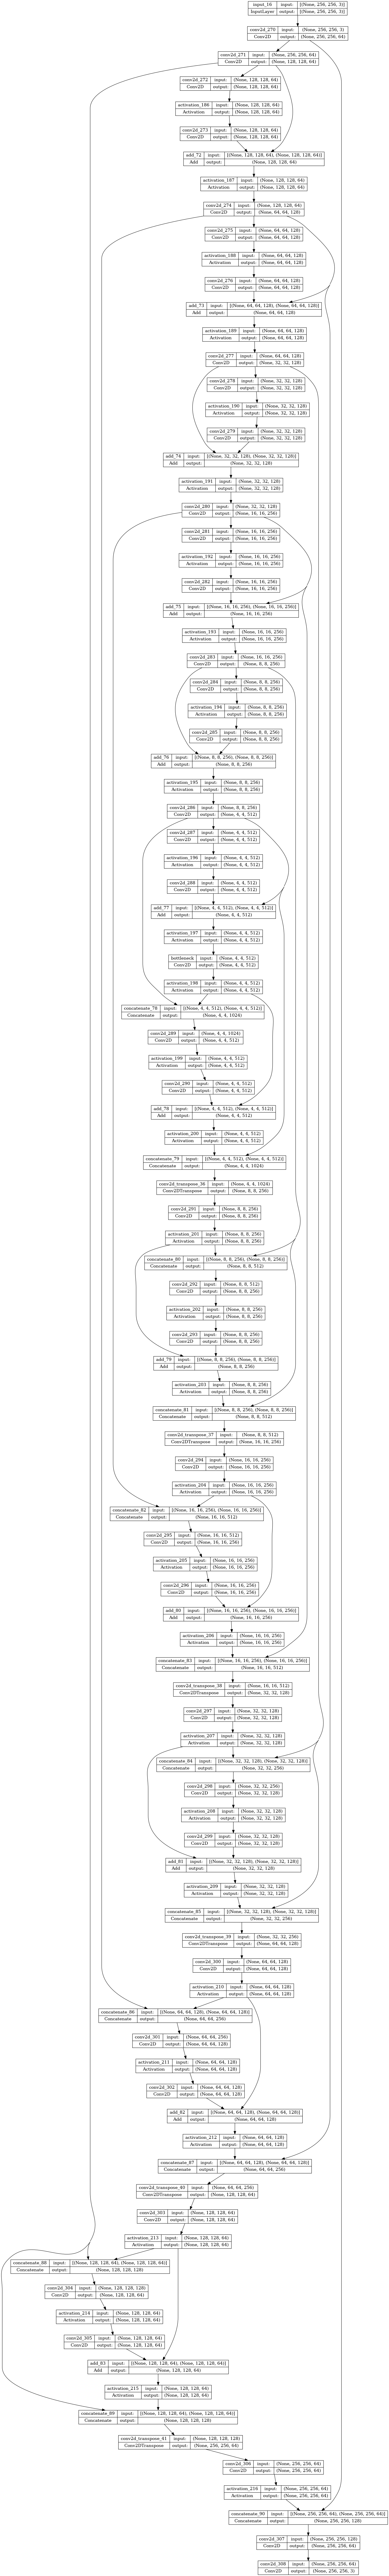

In [26]:
plot_model(UNet.RESNET.build_model(input_image_size,filters,kernels).get_model(),to_file="MODEL2.png",show_shapes=True,expand_nested=True)

## 4) Results
Our model is trained, and we can look at it's performance

1/1 [==============================] - 0s 154ms/step
(256, 256)
1/1 [==============================] - 0s 28ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 30ms/step
Outputs generated on previously unseen data.


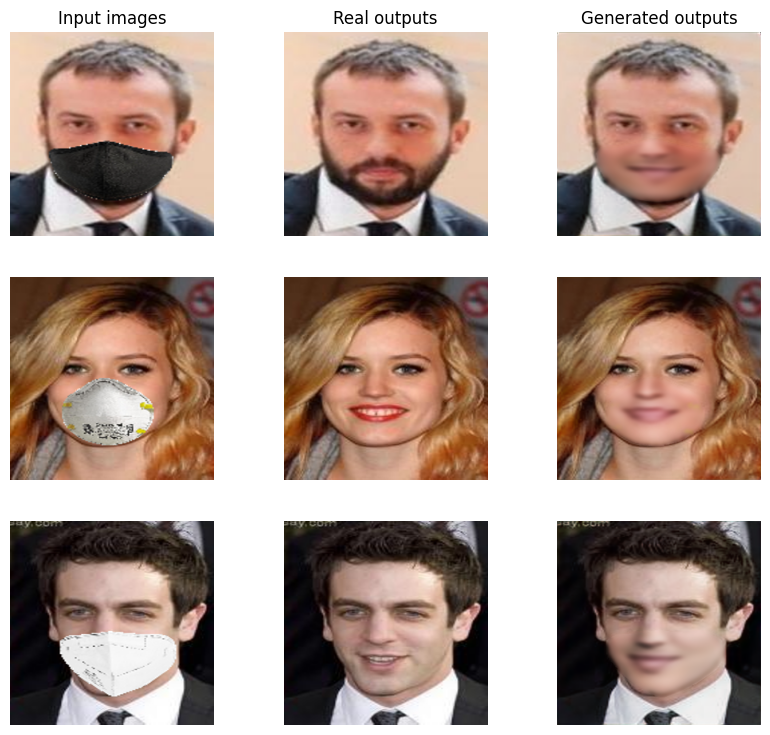

In [8]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))

for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

In [10]:
model.save_weights("pretrained_model",save_format="h5")

In [13]:
model.save("new_model",save_format="tf")

ValueError: Model <utils.model.Mask2FaceModel object at 0x7fd0a5ad2490> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [11]:
trained_model = Mask2FaceModel.load_model("models/model_epochs-40_batch-20_loss-ms_ssim_l1_perceptual_loss_20230210_15_45_38.h5")

ValueError: Exception encountered when calling layer "attention" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 8, 8, 256), dtype=float32).

Call arguments received by layer "attention" (type Attention):
  • inputs=tf.Tensor(shape=(None, 8, 8, 256), dtype=float32)
  • mask=None
  • training=False
  • return_attention_scores=False

1/1 [==============================] - 0s 31ms/step
(121, 141)
1/1 [==============================] - 0s 34ms/step


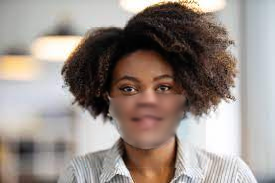

In [12]:
model.predict("Temp_data/test2.jpeg")

1/1 [==============================] - 0s 22ms/step
(245, 256)
1/1 [==============================] - 0s 33ms/step


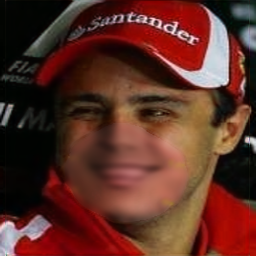

In [13]:
model.predict("data/test/inputs/000024.png")

In [15]:
model.save_weights("pretrained_model",save_format="h5")

In [14]:
!mkdir model_weights

/bin/bash: /home/suresh/miniconda3/envs/unmask/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [15]:
weights_path = "model_weights/model_epochs-40_batch-20_loss-ms_ssim_l1_perceptual_loss_20230210_15_45_38.ckpt"
model.save_weights(weights_path)

## Testing 

In [1]:
from utils.model import ModelLoss
from utils.model import Mask2FaceModel
from utils.configuration import Configuration
from utils.architectures import UNet
import tensorflow as tf

configuration = Configuration()
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESIDUAL_ATTENTION_UNET_SEPARABLE_CONV

trained_model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
trained_model.compile(
            loss=ModelLoss.ms_ssim_l1_perceptual_loss,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
        )

2023-03-13 18:46:46.602944: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 18:46:50.117524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 18:46:50.970368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14182 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6


Using UNet Resnet model with attention mechanism and separable convolutions


In [2]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 64  403        ['input_2[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 64  7296       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [3]:
weights_path = "model_weights/model_epochs-40_batch-20_loss-ms_ssim_l1_perceptual_loss_20230210_15_45_38.ckpt"
trained_model.load_weights(weights_path)

1/1 [==============================] - 0s 119ms/step
(155, 195)


2023-03-13 18:47:07.036959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 5s 5s/step


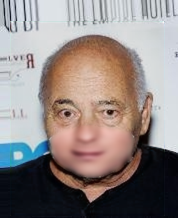

In [4]:
trained_model.predict("/home/suresh/Project_unmask/Archives/mask2face/data/temp/inputs/000051.jpg")

1/1 [==============================] - 0s 32ms/step
(224, 247)
1/1 [==============================] - 0s 29ms/step


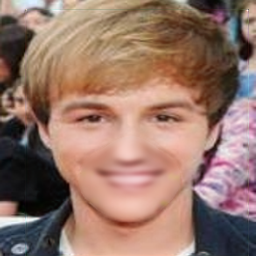

In [8]:
trained_model.predict("data/_test/inputs/000027.png")

1/1 [==============================] - 0s 26ms/step
(224, 247)
1/1 [==============================] - 0s 28ms/step
Time taken to predict the image:  0.6629743576049805


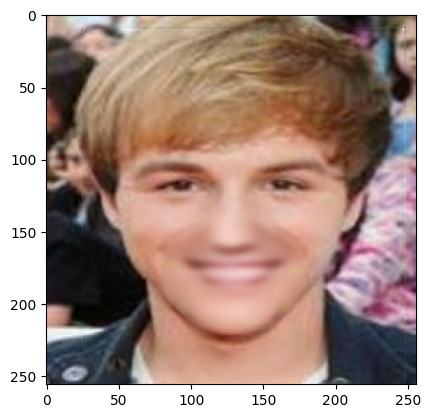

In [11]:
# Code to get execution time of the prediction
import time
import matplotlib.pyplot as plt
start = time.time()
predicted_image = trained_model.predict("data/_test/inputs/000027.png")
end = time.time()
print("Time taken to predict the image: ", end - start)

plt.imshow(predicted_image)